In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, "../models/")
from baseline import *
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

In [2]:
# utility functions

# display image from thumbnails folder given list of ids
def show_images(imgids):
    for img in imgids:
        plt.figure()
        try:
            img=mpimg.imread('../data/thumbnail/'+img+'.jpg')
            imgplot = plt.imshow(img)
        except:
            pass
    plt.show()

In [3]:
# similarity metrics

# returns number of exact tag overlap
def baseline_score(t0,t1):
    return len(set(t0) & set(t1))

# returns {exact matches} + eta*{synonym matches}
def syn_score(t0, t1, eta=0.5):
    score = len(set(t0) & set(t1))
    for tag in t0:
        for syn in wordnet.synsets(tag):
            for name in syn.lemma_names():
                if name in t1:
                    score += eta
    return score

# returns sum({exact match}*{tfidf val})
def tfidf_score(tfidf_df, t0, test):
    ref = tfidf_df.loc[test,:]
    score = 0
    for t in t0:
        for i in test:
            if t == i:
                score += ref[i]
    return score

In [14]:
# KNN model 
class KNN():
    # @param k: number of neighbors to return
    def __init__(self, k):
        self.k = k
    
    # @param train: training set of articles 
    # @article_to_image: map of images associated with each article
    def fit(self, train, article_to_image):
        self.train = train
        self.article_to_image = article_to_image
    
    # @param sim: function to return similarity score 
    # @param test: article to predict in form (id, tags)
    # TODO: implement sep functions for text train and image train
    def predict(self, sim, test):
        test_id, test_tags = test
        self.ranks = {}
        for train_id, train_tags in tqdm(self.train):
            s = sim(train_tags, test_tags)
            if len(self.ranks) < self.k:
                self.ranks[len(self.ranks)] = (train_id, s)
            elif s > min(self.ranks.values(), key=lambda x:x[1])[1]:
                key = min(self.ranks.keys(), key=lambda x:self.ranks[x][1])
                self.ranks[key] = (train_id, s)
        self.ranks = sorted(self.ranks.values(), key = lambda x:x[1], reverse=True)
        print(self.ranks)
        # map to predicted images
        self.pred = []
        for train_id, s in self.ranks:
            self.pred += self.article_to_image[train_id]
        return self.pred
    
    def score(self):
        pass

In [5]:
# extract tag data and format as dictionary

data_dir = "../data/csv_outputs/"
article_feats = {}
image_feats = {}
tag_ref = {'event':'event_tag',
           'org':'org_tag',
           'org_industry':'org_industry_tag',
           'person':'person_tag',
           'person_team':'person_team_tag',
           'person_type':'person_type',
           'place':'place_tag',
           'subject':'subject_tag',
           'summary':'headline_extended'
          }
for csv in tqdm(os.listdir(data_dir)):
    if 'ap_category' not in csv: # skip ap category for now
        df = pd.read_csv(data_dir+csv)
        if 'article' in csv:
            feat = csv[8:-4]
            g = df.groupby("id")[tag_ref[feat]]
            article_feats[feat] = g.apply(lambda x: list(x.astype(str).str.lower()))
        elif 'image' in csv:
            feat = csv[6:-4]
            g = df.groupby("id")[tag_ref[feat]]
            image_feats[feat] = g.apply(lambda x: list(x.astype(str).str.lower()))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  7.99s/it]


In [6]:
# format accessible image and article corpus
# TODO: some ids don't overlap

images = []
for imgid, tags in tqdm(image_feats['subject'].iteritems()):
    images.append({'imgid':imgid, 'tags': tags})

# images associated with an article
df = pd.read_csv('../data/csv_outputs/image_subject.csv')
g = df.groupby("article_idx")['id']
article_images = g.apply(list).to_dict()

articles = []
# displayable
for articleid, tags in tqdm(article_feats['subject'].iteritems()):
    if articleid in article_images.keys():
        articles.append((articleid,tags))

11087it [00:00, 352196.38it/s]
30098it [00:00, 668209.60it/s]


["utah authorities say a man killed after leading police on a chase down a busy street is 37-year-old man from the salt lake city suburb of west valley city. salt lake city police said in a news release monday afternoon that the deceased is harold vincent robinson. authorities wouldn't say if the suspect was killed by police gunfire or due to injuries from his truck crashing into a building."]


100%|██████████████████████████████████████████████████████████████████████████| 7237/7237 [00:00<00:00, 209751.43it/s]


[('9b1a9305f54d4f7883e725973c24586d', 10), ('46587b8b5f9f4664b876397c1e104db0', 10), ('5bbc1fccb92748a494e299596016f570', 9)]
['d3f2fa3331334b7baffb897b0cc0a836', 'd3f2fa3331334b7baffb897b0cc0a836', '3943d8b168ae4edd86c998f9b7a66b6b', '3943d8b168ae4edd86c998f9b7a66b6b', '3943d8b168ae4edd86c998f9b7a66b6b', '41ca89cabc614e96be34571d013cf579', '41ca89cabc614e96be34571d013cf579', '41ca89cabc614e96be34571d013cf579', '622d7062a93940a78006e990f340b21c', '622d7062a93940a78006e990f340b21c', '622d7062a93940a78006e990f340b21c', 'aee0ec5e69a143b4a4ba197e1fbf3be6', 'aee0ec5e69a143b4a4ba197e1fbf3be6', 'aee0ec5e69a143b4a4ba197e1fbf3be6', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b', 'c06aedf2c59d4d698199e87a652e491b']


C:\Users\Dianne\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


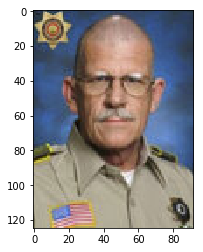

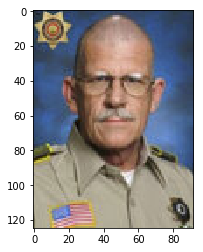

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
# knn example use case
# predict for first article

test = articles[0]
train = articles[1:]

# test article
print(article_feats['summary'][test[0]])

model = KNN(3)
model.fit(train, article_images)
preds = model.predict(baseline_score, test)
print(preds)
show_images(preds)

In [12]:
exact_match = baseline_model(test[1], images, 10, baseline_score)
syn_match = baseline_model(test[1], images, 10, lambda x,y: syn_score(x,y,eta=0.5))
print(syn_match)

[('0002c8b6322446a8a9b8f8abaccb4430', 0), ('0006323cab994ddd9c0824d14c2146fd', 0), ('001329af20914404b6609d9b05def407', 0)]
